### RNN을 사용한 문장 생성

In [1]:
import sys
sys.path.append('..')
import numpy as np
from common.functions import softmax
from rnnlm import Rnnlm
from better_rnnlm import BetterRnnlm

class RnnlnGen(Rnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x)
            p = softmax(score.flatten())

            sampled = np.random.choice(len(p), size=1, p=p)
            if(skip_ids is None or sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))

        return word_ids



In [2]:
import sys
sys.path.append('..')
from rnnlm_gen import RnnlmGen
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()

start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]

word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)

you potentially military chairs vacated st. zenith deterioration rampant bumiputra speech favor devastation mattel helpful roderick trade armed afloat count trelleborg columbia comparable pressing actress unidentified win inhibit baltimore reaction rewrite armed alleged acquirer indexing processed highlight wholly head disk-drive detect ongoing capita neuberger announcer consolidate horse associates concentrated overruns factor pointing readers russell thomson set portions earns historical bacteria theatre runaway lbos frightened whatever lined upper biggest far-reaching reported reproductive governors civilian expenses subscribe education haunts tele-communications casinos brain canton syndicates handful dismal firms editorial-page storage dialing broadcast evening list malcolm francisco applies aware guterman characterized basket emerson supervisor


In [3]:
model.reset_state()

start_words = 'the meaning of life is'
start_ids = [word_to_id[w] for w in start_words.split(' ')]

for x in start_ids[:-1]:
    x = np.array(x).reshape(1, 1)
    model.predict(x)

word_ids = model.generate(start_ids[-1], skip_ids)
word_ids = start_ids[:-1] + word_ids
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print('-' * 50)
print(txt)

--------------------------------------------------
the meaning of life is conference receive moody environmentalists excitement col. jamaica dairy hammond pot ceiling parking rarely challenging custody honduras pump spain deeply king minpeco landmark park drafted runaway shell scott opened neighbors figuring highlight midday noticed insist hot smooth radio laurel sperry merchant department-store figures ariz. el abrams petition porter focuses distributing protein sansui labeled corporations full-time rejected non-interest allow depletion lived unique entering talks wants only prosecuted banned hailed clears inflation-adjusted injunction bullet retailers deserves bart on amazing approached spree medium cooperate fans diminished profitable scripts referred lion cbs defendants winners woman climbed adjustments jokes art provision psychiatric islands exemption 300-a-share


### seq2seq

In [1]:
import sys
sys.path.append('..')
from dataset import sequence


(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt', seed=1984)
char_to_id, id_to_char = sequence.get_vocab()

print(x_train.shape, t_train.shape)
print(x_test.shape, t_test.shape)
# (45000, 7) (45000, 5)
# (5000, 7) (5000, 5)

print(x_train[0])
print(t_train[0])
# [ 3  0  2  0  0 11  5]
# [ 6  0 11  7  5]

print(''.join([id_to_char[c] for c in x_train[0]]))
print(''.join([id_to_char[c] for c in t_train[0]]))
# 71+118
# _189

(45000, 7) (45000, 5)
(5000, 7) (5000, 5)
[ 3  0  2  0  0 11  5]
[ 6  0 11  7  5]
71+118 
_189 


In [2]:
class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)

        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None

    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :]

    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh

        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

In [3]:
class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, h):
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))

        return sampled



In [5]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.base_model import BaseModel

class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]

        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss

    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout

    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.53
| 에폭 1 |  반복 41 / 351 | 시간 0[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 1[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 1[s] | 손실 1.92
| 에폭 1 |  반복 101 / 351 | 시간 2[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 2[s] | 손실 1.85
| 에폭 1 |  반복 141 / 351 | 시간 2[s] | 손실 1.83
| 에폭 1 |  반복 161 / 351 | 시간 3[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 3[s] | 손실 1.77
| 에폭 1 |  반복 201 / 351 | 시간 4[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 5[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 5[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 5[s] | 손실 1.76
| 에폭 1 |  반복 281 / 351 | 시간 6[s] | 손실 1.75
| 에폭 1 |  반복 301 / 351 | 시간 6[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 7[s] | 손실 1.75
| 에폭 1 |  반복 341 / 351 | 시간 8[s] | 손실 1.74
Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1000
---
Q 582+84 
T 666 
☒ 1000
---
Q 8+155  
T 163 
☒ 100 
---
Q 367+55 
T 422 
☒ 1000
---
Q 600+257
T 857 
☒ 1000
---
Q 761+292
T 1053
☒ 1000
---
Q 830+597
T 1427
☒ 1000
---
Q 26+838

/Users/chohi/project/ai/DeepLearningDeepen/DeepLearningAdv/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chohi/project/ai/DeepLearningDeepen/DeepLearningAdv/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54253 (\N{HANGUL SYLLABLE POG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chohi/project/ai/DeepLearningDeepen/DeepLearningAdv/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chohi/project/ai/DeepLearningDeepen/DeepLearningAdv/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_i

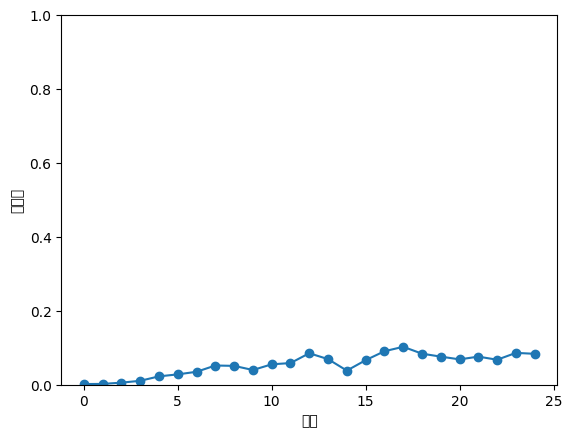

In [7]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
# from seq2seq import Seq2seq
# from peeky_seq2seq import PeekySeq2seq


# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 =============================================
is_reverse = False  # True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
model = Seq2seq(vocab_size, wordvec_size, hidden_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()

### seq2seq 개선

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.52
| 에폭 1 |  반복 41 / 351 | 시간 1[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 1[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 1[s] | 손실 1.91
| 에폭 1 |  반복 101 / 351 | 시간 2[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 2[s] | 손실 1.86
| 에폭 1 |  반복 141 / 351 | 시간 3[s] | 손실 1.84
| 에폭 1 |  반복 161 / 351 | 시간 3[s] | 손실 1.80
| 에폭 1 |  반복 181 / 351 | 시간 4[s] | 손실 1.78
| 에폭 1 |  반복 201 / 351 | 시간 4[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 4[s] | 손실 1.77
| 에폭 1 |  반복 241 / 351 | 시간 5[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 5[s] | 손실 1.75
| 에폭 1 |  반복 281 / 351 | 시간 6[s] | 손실 1.74
| 에폭 1 |  반복 301 / 351 | 시간 6[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 6[s] | 손실 1.74
| 에폭 1 |  반복 341 / 351 | 시간 7[s] | 손실 1.73
Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1000
---
Q 582+84 
T 666 
☒ 1001
---
Q 8+155  
T 163 
☒ 100 
---
Q 367+55 
T 422 
☒ 1001
---
Q 600+257
T 857 
☒ 1000
---
Q 761+292
T 1053
☒ 1000
---
Q 830+597
T 1427
☒ 1000
---
Q 26+838

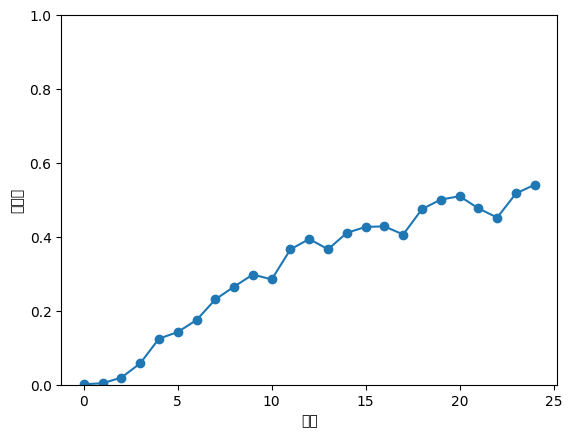

In [8]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq


# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 =============================================
is_reverse = True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
model = Seq2seq(vocab_size, wordvec_size, hidden_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()

### Peeky

In [11]:
import sys
sys.path.append('..')
from common.time_layers import *
#from seq2seq import Seq2seq, Encoder


class PeekyDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(H + D, 4 * H) / np.sqrt(H + D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H + H, V) / np.sqrt(H + H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        self.cache = None

    def forward(self, xs, h):
        N, T = xs.shape
        N, H = h.shape

        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        hs = np.repeat(h, T, axis=0).reshape(N, T, H)
        out = np.concatenate((hs, out), axis=2)

        out = self.lstm.forward(out)
        out = np.concatenate((hs, out), axis=2)

        score = self.affine.forward(out)
        self.cache = H
        return score

    def backward(self, dscore):
        H = self.cache

        dout = self.affine.backward(dscore)
        dout, dhs0 = dout[:, :, H:], dout[:, :, :H]
        dout = self.lstm.backward(dout)
        dembed, dhs1 = dout[:, :, H:], dout[:, :, :H]
        self.embed.backward(dembed)

        dhs = dhs0 + dhs1
        dh = self.lstm.dh + np.sum(dhs, axis=1)
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        char_id = start_id
        self.lstm.set_state(h)

        H = h.shape[1]
        peeky_h = h.reshape(1, 1, H)
        for _ in range(sample_size):
            x = np.array([char_id]).reshape((1, 1))
            out = self.embed.forward(x)

            out = np.concatenate((peeky_h, out), axis=2)
            out = self.lstm.forward(out)
            out = np.concatenate((peeky_h, out), axis=2)
            score = self.affine.forward(out)

            char_id = np.argmax(score.flatten())
            sampled.append(char_id)

        return sampled


class PeekySeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = PeekyDecoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.57
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.48
| 에폭 1 |  반복 41 / 351 | 시간 1[s] | 손실 2.20
| 에폭 1 |  반복 61 / 351 | 시간 1[s] | 손실 1.99
| 에폭 1 |  반복 81 / 351 | 시간 2[s] | 손실 1.89
| 에폭 1 |  반복 101 / 351 | 시간 2[s] | 손실 1.82
| 에폭 1 |  반복 121 / 351 | 시간 2[s] | 손실 1.82
| 에폭 1 |  반복 141 / 351 | 시간 3[s] | 손실 1.80
| 에폭 1 |  반복 161 / 351 | 시간 3[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 4[s] | 손실 1.78
| 에폭 1 |  반복 201 / 351 | 시간 4[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 5[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 5[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 5[s] | 손실 1.75
| 에폭 1 |  반복 281 / 351 | 시간 6[s] | 손실 1.74
| 에폭 1 |  반복 301 / 351 | 시간 6[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 7[s] | 손실 1.73
| 에폭 1 |  반복 341 / 351 | 시간 7[s] | 손실 1.73
Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1013
---
Q 582+84 
T 666 
☒ 102 
---
Q 8+155  
T 163 
☒ 100 
---
Q 367+55 
T 422 
☒ 1023
---
Q 600+257
T 857 
☒ 1023
---
Q 761+292
T 1053
☒ 1023
---
Q 830+597
T 1427
☒ 1111
---
Q 26+838

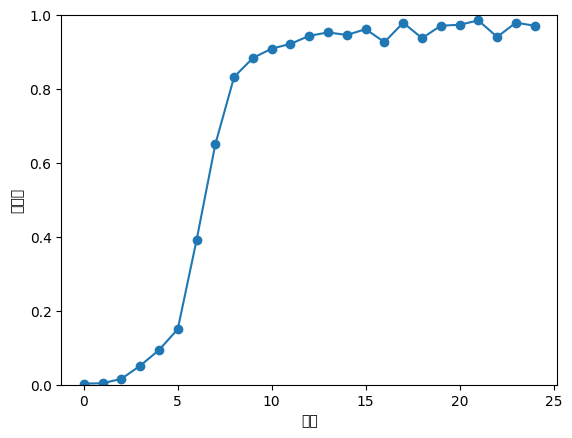

In [12]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq


# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 =============================================
is_reverse = True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
# model = Seq2seq(vocab_size, wordvec_size, hidden_size)
model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()